In [1]:
%load_ext autoreload
import uproot as ut
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import re
import sympy as sp
import math
import vector


from tqdm import tqdm
import timeit

from utils import *
%autoreload 2

In [2]:
use_config_v1 = lambda flist : [ f.replace("QCD_SR","QCD_SR/config-v1") for f in flist ]

In [3]:
data_tree = Tree( use_config_v1(fc.qcd_sr.JetHT_Data_UL_List) ,lazy=True)

In [4]:
qcd_tree = Tree( use_config_v1(fc.qcd_sr.QCD_B_List) ,lazy=True)

In [5]:
trees = [data_tree,qcd_tree]

In [52]:
scaled_cutflow = lambda tree : np.sum(tree.cutflow*np.array(tree.scales)[:,np.newaxis],axis=0)

In [57]:
print(scaled_cutflow(qcd_tree)*lumiMap[2018][0])
print(scaled_cutflow(data_tree))

[1.53116492e+11 1.16762685e+07]
[6.41046792e+08 2.45650530e+07]


In [6]:
for tree in trees: print_raw_info(tree)

JetHT\_Run2018A & N/A & 160697632 & 7018307\\
JetHT\_Run2018B & N/A & 71804584 & 3219907\\
JetHT\_Run2018C & N/A & 68099424 & 2798893\\
JetHT\_Run2018D & N/A & 340445152 & 11527946\\
QCD\_bEnriched\_HT100to200 & 1127000.0 & 38498992 & 41\\
QCD\_bEnriched\_HT200to300 & 80430.0 & 19407546 & 1101\\
QCD\_bEnriched\_HT300to500 & 16620.0 & 12042685 & 52578\\
QCD\_bEnriched\_HT500to700 & 1487.0 & 10381843 & 253368\\
QCD\_bEnriched\_HT700to1000 & 296.5 & 2031431 & 83878\\
QCD\_bEnriched\_HT1000to1500 & 46.61 & 474198 & 28242\\
QCD\_bEnriched\_HT1500to2000 & 3.72 & 411724 & 28726\\
QCD\_bEnriched\_HT2000toInf & 0.6462 & 401397 & 24572\\
QCD\_HT100to200\_BGenFilter & 1275000.0 & 36346204 & 28\\
QCD\_HT200to300\_BGenFilter & 111700.0 & 18762564 & 300\\
QCD\_HT300to500\_BGenFilter & 27960.0 & 17127050 & 18713\\
QCD\_HT500to700\_BGenFilter & 3078.0 & 8292039 & 63215\\
QCD\_HT700to1000\_BGenFilter & 721.8 & 5952088 & 90198\\
QCD\_HT1000to1500\_BGenFilter & 138.2 & 1953159 & 48931\\
QCD\_HT1500to2000

In [7]:
jet_pts = [ tree["jet_pt"] for tree in trees ]
jet_btags = [ tree["jet_btag"] for tree in trees ]
jet_etas = [ tree["jet_eta"] for tree in trees ]
jet_phis = [ tree["jet_phi"] for tree in trees ]

In [8]:
weights = [None,qcd_tree["scale"]]

In [9]:
ptbins = [20,30,40,50]
njet_ptbins = [ [ ak.sum(jet_pt>pt,axis=-1) for jet_pt in jet_pts ] for pt in ptbins ]

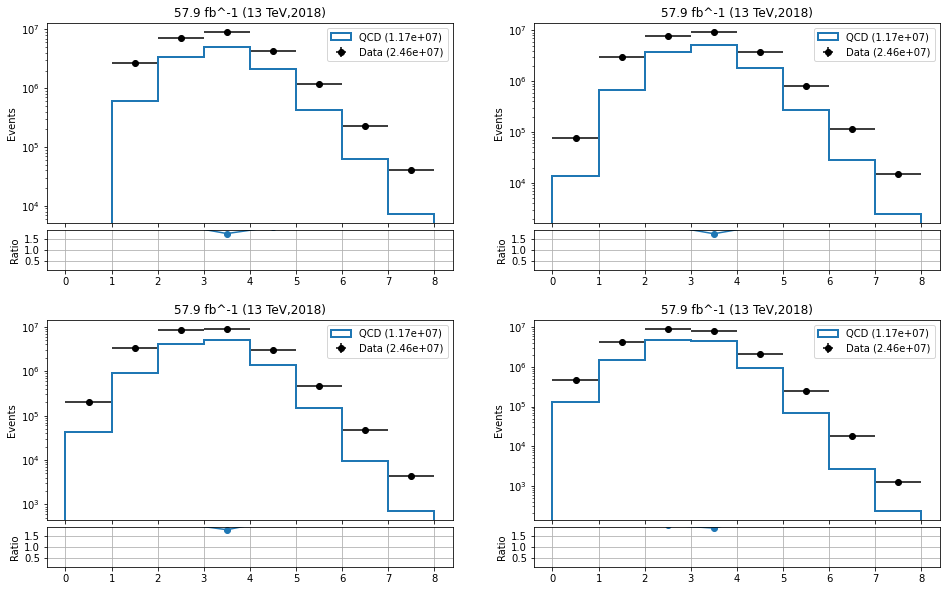

In [23]:
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(16,10))

info = dict(weights=weights,labels=["Data","QCD"],log=1,ratio=1,r_ylim=(0.1,1.9),r_grid=True,is_datas=[True,False],lumikey=2018,bins=range(9))
for i,njet_ptbin in enumerate(njet_ptbins):
    hist_multi(njet_ptbin,**info,figax=(fig,axs[i//2,i%2]))

In [14]:
btagwps = [1,2,3]
njet_btagwps = [ [ ak.sum(jet_btag>jet_btagWP[wp],axis=-1) for jet_btag in jet_btags ] for wp in btagwps ]

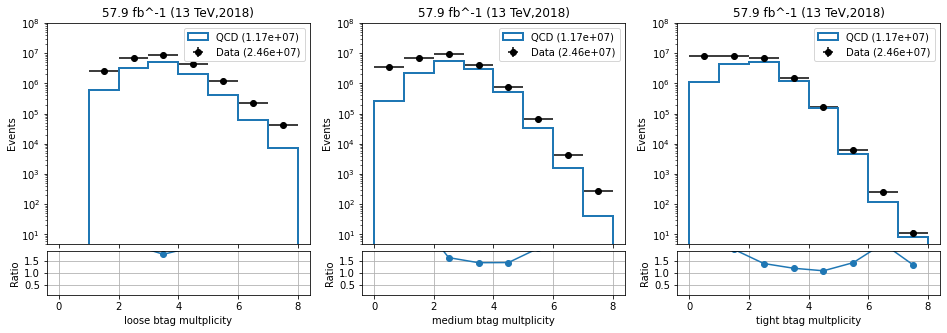

In [29]:
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(16,5))

info = dict(weights=weights,labels=["Data","QCD"],log=1,ratio=1,r_grid=1,r_ylim=(0.1,1.9),ylim=(5,1e8),is_datas=[True,False],lumikey=2018,bins=range(9))
for i,njet_btagwp in enumerate(njet_btagwps):
    hist_multi(njet_btagwp,**info,xlabel=f"{wplabels[i+1]} btag multplicity",figax=(fig,axs[i]))
save_fig(fig,"","njet_btagwp")

In [16]:
mask_arrays = lambda arrays,masks : [ (array[mask] if array is not None else None) for array,mask in zip(arrays,masks) ]
ijet = lambda jets,i : [ jet[:,i] for jet in jets ]

In [59]:
masks = [ njet_btagwp >2 for njet_btagwp in njet_btagwps[2] ]
mask_weights = mask_arrays(weights,masks)

In [18]:
cache = {}

branches = {
    "pt":jet_pts,
    "btag":jet_btags,
    "eta":jet_etas,
    "phi":jet_phis
}

def get_cache(i,key,cache=cache):
    ikey = f"{key}_{i}"
    if ikey not in cache: cache[ikey] = ijet(mask_arrays( branches[key],masks),i)
    return cache[ikey]

In [30]:
def make_ijet_plots(i):
    j_pt =   get_cache(i,"pt")
    j_btag = get_cache(i,"btag")
    j_eta =  get_cache(i,"eta")
    j_phi =  get_cache(i,"phi")

    fig,axs = plt.subplots(nrows=1,ncols=4,figsize=(20,5))
    info = dict(weights=mask_weights,log=1,ratio=1,r_ylim=(0.1,1.9),r_grid=True,is_datas=[True,False],ylim=(0.1,1e8),lumikey=2018)
    hist_multi(j_pt,**info  ,**varinfo["jet_pt"]  ,figax=(fig,axs[0]));
    hist_multi(j_btag,**info,**varinfo["jet_btag"],figax=(fig,axs[1]));
    hist_multi(j_eta,**info ,**varinfo["jet_eta"] ,figax=(fig,axs[2]));
    hist_multi(j_phi,**info ,**varinfo["jet_phi"] ,figax=(fig,axs[3]));

    fig.suptitle(f"{ordinal(i+1)} Jet Distribution")
    save_fig(fig,"ntight3",f"jet{i}")
    plt.show()

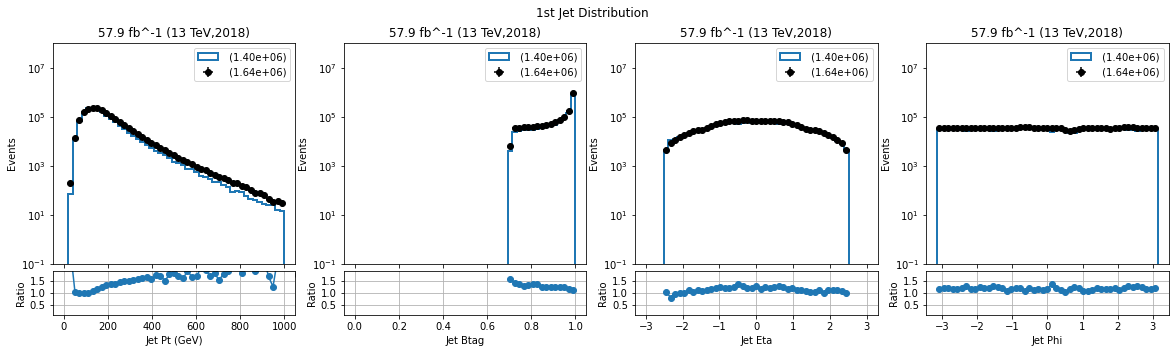

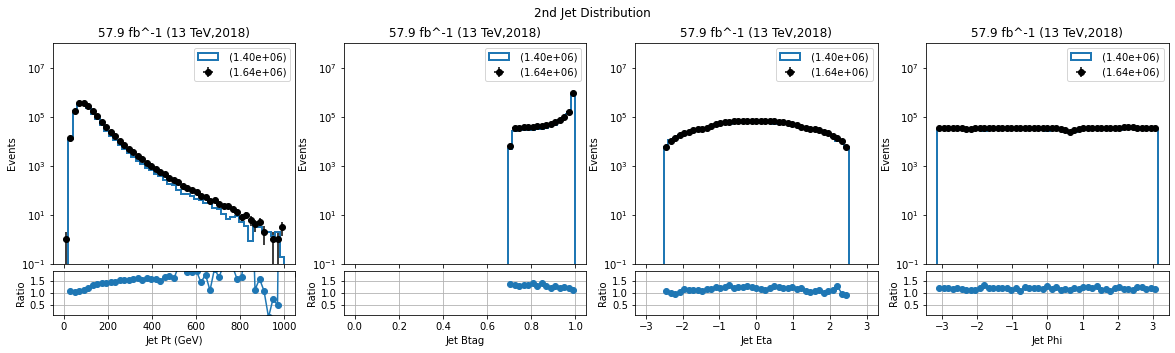

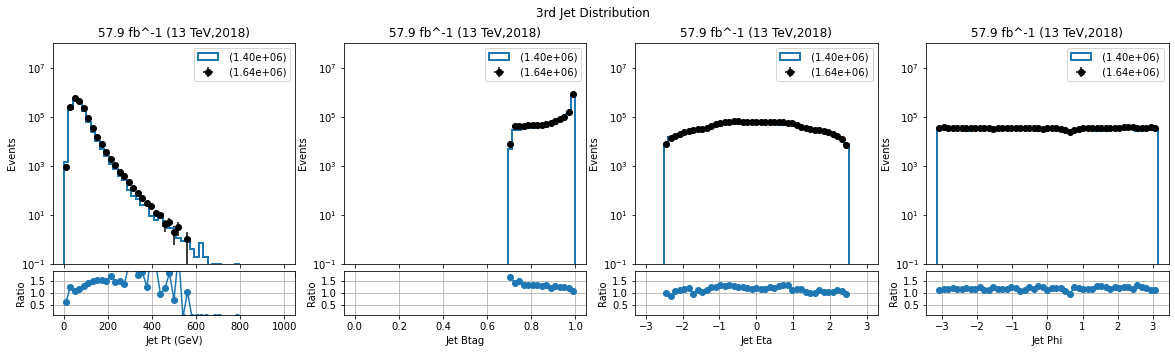

In [31]:
make_ijet_plots(0)
make_ijet_plots(1)
make_ijet_plots(2)

In [61]:
rhofastjet = mask_arrays([tree["rhofastjet_all"] for tree in trees],masks)

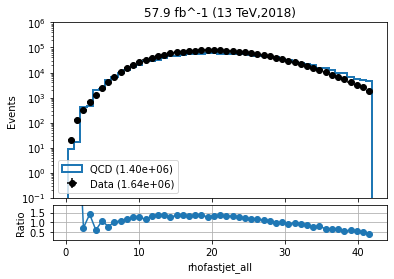

In [67]:
info = dict(weights=mask_weights,labels=["Data","QCD"],log=1,ratio=1,r_ylim=(0.1,1.9),r_grid=True,is_datas=[True,False],ylim=(0.1,1e6),lumikey=2018)
fig,ax=hist_multi(rhofastjet,**info,xlabel="rhofastjet_all");
save_fig(fig,"","qcd_sr_rhofastjet_all")